In [1]:
'''
In this file we train SketchVAE + SketchInpainter
'''
import torch 
from d2l import torch as d2l
from matplotlib import pyplot as plt
from pylab import *
import os
import numpy as np
from torch import optim
from torch.nn import functional as F
from SketchVAE.sketchvae import SketchVAE
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions import Normal
from SketchNet.sketchnet import SketchNet
from utils.helpers import *
import time

In [2]:

###############################
# initial parameters
s_dir = "" # folder_address
zp_dims = 128
zr_dims = 128
pf_dims = 512
gen_dims = 1024
combine_dims = 512
combine_head = 4
combine_num = 4
pf_num = 2

############# CHANGE PARAMETERS!!!!!!! ###############
# for A4, inpaint_len = 2, total_len = 4
# for B4, inpaint_len = 4, total_len = 12
inpaint_len = 2
total_len = 4
#######################################################

batch_size = 32
n_epochs = 1000

save_path = "model_backup"
A4_index=1
A4_path = "A4_"

while True:
    if os.path.exists(os.path.join(save_path,A4_path+f"{A4_index:03}")):
        A4_index+=1
    else:
        os.mkdir(os.path.join(save_path,A4_path+f"{A4_index:03}"))
        break


# set here to config your save_period (2 i.e. save the model every 2 epochs)
save_period = 10
data_path = ["data/POP909_train_4_chord_rhythm.npy",
             "data/POP909_test_4_chord_rhythm.npy",
             "data/POP909_validate_4_chord_rhythm.npy"]
lr = 1e-4
decay = 0.9999
##############################
##############  for vae init ##############
vae_hidden_dims = 1024
vae_zp_dims = 128
vae_zr_dims = 128
vae_beta = 0.1
vae_input_dims = 130
vae_pitch_dims = 129
vae_rhythm_dims = 3
vae_seq_len = 6 * 4
vae_beat_num = 4
vae_tick_num = 6
############################



In [3]:
train_set = np.load(os.path.join(s_dir,data_path[0]),allow_pickle = True)
print(train_set.shape)
# print(train_set[0])
print(train_set[0][0])

(2792, 4, 4)
[array([ 71, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128,  71, 128, 128, 128, 128, 128, 128, 128, 128,  71])
 array([ 71,  71,  71, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128])
 array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 1])
 3]


In [4]:
# input data dis-measure-vae
def processed_data_tensor(data):
    print("processed data:")
    gd = [] 
    px = []
    rx = []
    len_x = []
    nrx = []
    total = 0
    for i, d in enumerate(data):
        gd.append([list(dd[0]) for dd in d])
        px.append([list(dd[1]) for dd in d])
        rx.append([list(dd[2]) for dd in d])
        len_x.append([dd[3] for dd in d])
        if len(gd[-1][-1]) != vae_seq_len:
            gd[-1][-1].extend([128] * (vae_seq_len - len(gd[-1][-1])))
            px[-1][-1].extend([128] * (vae_seq_len - len(px[-1][-1])))
            rx[-1][-1].extend([2] * (vae_seq_len - len(rx[-1][-1])))
    for i,d in enumerate(len_x):
        for j,dd in enumerate(d):
            if len_x[i][j] == 0:
                gd[i][j][0] = 60
                px[i][j][0] = 60
                rx[i][j][0] = 1
                len_x[i][j] = 1
                total += 1
    gd = np.array(gd)
    px = np.array(px)
    rx = np.array(rx)
    len_x = np.array(len_x)
    for d in rx:
        nnrx = []
        for dd in d:
            temp = np.zeros((vae_seq_len, vae_rhythm_dims))
            lins = np.arange(0, len(dd))
            temp[lins, dd - 1] = 1
            nnrx.append(temp)
        nrx.append(nnrx)
    nrx = np.array(nrx)
    gd = torch.from_numpy(gd).long()
    px = torch.from_numpy(px).long()
    rx = torch.from_numpy(rx).float()
    len_x = torch.from_numpy(len_x).long()
    nrx = torch.from_numpy(nrx).float()
    print("processed finish! zeros:", total)
    print(gd.size(),px.size(),rx.size(),len_x.size(),nrx.size())
    return TensorDataset(px, rx, len_x, nrx, gd)

train_set = np.load(os.path.join(s_dir,data_path[0]),allow_pickle = True)
train_loader = DataLoader(
    dataset = processed_data_tensor(train_set),
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 8, 
    pin_memory = True,
    drop_last = True
)

validate_set = np.load(os.path.join(s_dir,data_path[1]),allow_pickle = True)
validate_loader = DataLoader(
    dataset = processed_data_tensor(validate_set),
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 8, 
    pin_memory = True, 
    drop_last = True
)
validate_data = []
for i,d in enumerate(validate_loader):
    validate_data.append(d)
print(len(validate_data))

processed data:
processed finish! zeros: 0
torch.Size([2792, 4, 24]) torch.Size([2792, 4, 24]) torch.Size([2792, 4, 24]) torch.Size([2792, 4]) torch.Size([2792, 4, 24, 3])
processed data:
processed finish! zeros: 0
torch.Size([398, 4, 24]) torch.Size([398, 4, 24]) torch.Size([398, 4, 24]) torch.Size([398, 4]) torch.Size([398, 4, 24, 3])
12


In [5]:
# load VAE model
vae_model = SketchVAE(
    vae_input_dims, vae_pitch_dims, vae_rhythm_dims, vae_hidden_dims, 
    vae_zp_dims, vae_zr_dims, vae_seq_len, vae_beat_num, vae_tick_num, 4000)

# sketchvae-param.pt is your saved sketchVAE model
dic = torch.load(os.path.join(s_dir, save_path, "sketchvae-param.pt"))

for name in list(dic.keys()):
    dic[name.replace('module.', '')] = dic.pop(name)
vae_model.load_state_dict(dic)

if torch.cuda.is_available():
    print('Using: ', torch.cuda.get_device_name(torch.cuda.current_device()))
    vae_model.cuda()
else:
    print('Using: CPU')
vae_model.eval()
print(vae_model.training)

Using:  Quadro P4000
False


In [6]:
# import model
model = SketchNet(
    zp_dims, zr_dims, 
    pf_dims, gen_dims, combine_dims,
    pf_num, combine_num, combine_head,
    inpaint_len, total_len, 
    vae_model, True
)

# dic = torch.load(os.path.join(s_dir, save_path, r"A4_001\sketchNet-stage-1loss_1.4091820511324653_acc_0.6329846144636017_epoch_100_it_8700.pt"))
dic = torch.load(os.path.join(s_dir, save_path, r"sketchNet-stage-1-pop909-4-measure.pt"))

for name in list(dic.keys()):
    dic[name.replace('module.', '')] = dic.pop(name)
model.load_state_dict(dic)
model.set_stage("sketch")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
if torch.cuda.is_available():
    print('Using: ', torch.cuda.get_device_name(torch.cuda.current_device()))
    model.cuda()
else:
    print('Using: CPU')
print(model)

Using:  Quadro P4000
SketchNet(
  (past_p_gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (past_r_gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (future_p_gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (future_r_gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (gen_p_gru): GRU(128, 1024, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (gen_r_gru): GRU(128, 1024, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (gen_p_out): Linear(in_features=2048, out_features=128, bias=True)
  (gen_r_out): Linear(in_features=2048, out_features=128, bias=True)
  (combine_in): Linear(in_features=256, out_features=512, bias=True)
  (combine_posenc): PositionalEncoding()
  (combine_dropout): Dropout(p=0.1, inplace=False)
  (combine_nn): ModuleList(
    (0): CombineLayer(
      (slf_attn): MultiHeadAttention(
      

In [7]:
def plot_loss(img_array):
    # fig, ax = plt.subplots(figsize=(n, 2.7))
    array_len=len(img_array)
    figure(figsize=(10, 5))
    subplot(1,1,1)
    y1=[]
    y2=[]
    y3=[]
    y4=[]
    for i in range(array_len):
        y1.append(img_array[i][0])
        y2.append(img_array[i][1])
        y3.append(img_array[i][2])
        y4.append(img_array[i][3])
    epoch = list(range(1,len(y1)+1))

    plot(epoch,y1, label="mean_loss") 
    plot(epoch,y2, label="v_mean_loss")
    plot(epoch,y3, label="mean_acc")
    plot(epoch,y4, label="v_mean_acc")
    legend(loc='upper right')
    xlim(0,100)  # Add an x-label to the axes.
    ylim(0,3)  # Add a y-label to the axes.
    xticks(np.linspace(0,100,11,endpoint=True))
    # scatter([100,],[y1[-1],], 50, color ='blue')


    show()

    # ax.plot(epoch,y1, label="mean_loss") 
    # ax.plot(epoch,y2, label="v_mean_loss")
    # ax.plot(epoch,y3, label="mean_acc")
    # ax.plot(epoch,y4, label="v_mean_acc")
    
    # ax.set_xlabel('epoch')  # Add an x-label to the axes.
    # ax.set_ylabel('Loss and Acc')  # Add a y-label to the axes.
    # ax.set_title("Loss and Acc")  # Add a title to the axes.
    # ax.legend()


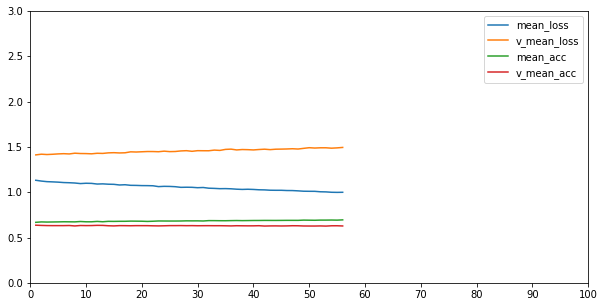

In [8]:
img_array = np.load(os.path.join("log_A4",f"sketchnet_A4_stage1_log056.npy"),allow_pickle=True)
plot_loss(img_array)

In [9]:
def process_raw_x(raw_x, n_past, n_inpaint, n_future):
    raw_px, raw_rx, raw_len_x, raw_nrx, raw_gd = raw_x
    past_px = raw_px[:,:n_past,:]
    inpaint_px = raw_px[:,n_past:n_past + n_inpaint,:]
    future_px = raw_px[:,n_future:,:]
    past_rx = raw_rx[:,:n_past,:]
    inpaint_rx = raw_rx[:,n_past:n_past + n_inpaint,:]
    future_rx = raw_rx[:,n_future:,:]
    past_len_x = raw_len_x[:,:n_past]
    inpaint_len_x = raw_len_x[:,n_past:n_past + n_inpaint]
    future_len_x = raw_len_x[:,n_future:]
    past_nrx = raw_nrx[:,:n_past,:]
    inpaint_nrx = raw_nrx[:,n_past:n_past + n_inpaint,:]
    future_nrx = raw_nrx[:,n_future:,:]
    past_gd = raw_gd[:,:n_past,:]
    inpaint_gd = raw_gd[:,n_past:n_past + n_inpaint,:]
    future_gd = raw_gd[:,n_future:,:]
    re = [
        past_px, past_rx, past_len_x, past_nrx, past_gd,
        inpaint_px, inpaint_rx, inpaint_len_x, inpaint_nrx, inpaint_gd,
        future_px, future_rx, future_len_x, future_nrx, future_gd,
    ]
    return re
def get_acc(recon, gd):
    recon = recon.cpu().detach().numpy()
    gd = gd.cpu().detach().numpy()
    return np.sum(recon == gd) / recon.size

model.set_stage = "inpainting"
device = torch.device(torch.cuda.current_device())
losses_accs = []

############# CHANGE PARAMETERS!!!!!!! ###############
# for A4, n_past = 1, n_future = 3, n_inpaint = 2
# for B4, n_past = 4, n_future = 8, n_inpaint = 4
n_past = 1
n_future = 3
n_inpaint = 2
#######################################################
step = 0
iteration = 0
# save_period = 200
print(vae_model.training)



# create log folder
log_path="log_A4"
log_index=1

if not os.path.exists(log_path):
    os.mkdir(log_path)

for epoch in range(n_epochs):
    model.train()
    print("epoch: %d\n__________________________________________" % (epoch), flush = True)
    mean_loss = 0.0
    mean_acc = 0.0
    v_mean_loss = 0.0
    v_mean_acc = 0.0
    total = 0
    for i,tr_data in enumerate(train_loader):
        model.train()
#         print("begin_time", time.process_time())
        j = i % len(validate_data)
        raw_x = process_raw_x(tr_data, n_past, n_inpaint, n_future)
        for k in range(len(raw_x)):
            raw_x[k] = raw_x[k].to(device = device,non_blocking = True)
        past_px, past_rx, past_len_x, past_nrx, past_gd, \
        inpaint_px, inpaint_rx, inpaint_len_x, inpaint_nrx, inpaint_gd,\
        future_px, future_rx, future_len_x, future_nrx, future_gd = raw_x
        inpaint_gd_whole = inpaint_gd.contiguous().view(-1)
        past_x = [past_px, past_rx, past_len_x, past_nrx, past_gd]
        inpaint_x = [inpaint_px, inpaint_rx, inpaint_len_x, inpaint_nrx, inpaint_gd]
        future_x = [future_px, future_rx, future_len_x, future_nrx, future_gd]
        
        # validate
        v_raw_x = process_raw_x(validate_data[j], n_past, n_inpaint, n_future)
        for k in range(len(v_raw_x)):
            v_raw_x[k] = v_raw_x[k].to(device = device,non_blocking = True)
        v_past_px, v_past_rx, v_past_len_x, v_past_nrx, v_past_gd, \
        v_inpaint_px, v_inpaint_rx, v_inpaint_len_x, v_inpaint_nrx, v_inpaint_gd,\
        v_future_px, v_future_rx, v_future_len_x, v_future_nrx, v_future_gd = v_raw_x
        v_inpaint_gd_whole = v_inpaint_gd.contiguous().view(-1)
        v_past_x = [v_past_px, v_past_rx, v_past_len_x, v_past_nrx, v_past_gd]
        v_inpaint_x = [v_inpaint_px, v_inpaint_rx, v_inpaint_len_x, v_inpaint_nrx, v_inpaint_gd]
        v_future_x = [v_future_px, v_future_rx, v_future_len_x, v_future_nrx, v_future_gd]
        
        optimizer.zero_grad()
        
        recon_x, iteration, use_teacher, stage = model(past_x, future_x, inpaint_x)

        loss = F.cross_entropy(recon_x.view(-1, recon_x.size(-1)), inpaint_gd_whole, reduction = "mean") 
        acc = get_acc(recon_x.view(-1, recon_x.size(-1)).argmax(-1), inpaint_gd_whole)
        loss.backward()
        optimizer.step()
   
        total += 1
        mean_loss += loss.item()
        mean_acc += acc
  
        model.eval()
        with torch.no_grad():
            v_recon_x, _,_,_ = model(v_past_x, v_future_x, v_inpaint_x)
            v_loss = F.cross_entropy(v_recon_x.view(-1, v_recon_x.size(-1)), v_inpaint_gd_whole, reduction = "mean") 
            v_acc = get_acc(v_recon_x.view(-1, v_recon_x.size(-1)).argmax(-1), v_inpaint_gd_whole)
            v_mean_loss += v_loss.item()
            v_mean_acc += v_acc

        # print("batch %d loss: %.5f acc: %.5f | v_loss: %.5f v_acc: %.5f |  iteration: %d teacher: %d stage: %s" \
        #       % (i,loss.item(), acc, v_loss.item(), v_acc, iteration, use_teacher, stage),flush = True)
    mean_loss /= total
    mean_acc /= total
    v_mean_loss /= total
    v_mean_acc /= total
    print("epoch %d loss: %.5f acc: %.5f | v_loss: %.5f v_acc: %.5f "  % (epoch,mean_loss, mean_acc, v_mean_loss, v_mean_acc),flush = True)
    losses_accs.append([mean_loss, v_mean_loss, mean_acc, v_mean_acc])
    while True:
        if os.path.exists(os.path.join(log_path,f"sketchnet_A4_stage1_log{log_index:03}.npy")):
            log_index += 1
        else:
            break
    if (epoch + 1) % save_period == 0:
        filename = "sketchNet-stage-1" + 'loss_' + str(v_mean_loss) + "_acc_" + str(v_mean_acc) + "_epoch_" + str(epoch+1) + '_it_' + str(iteration) + ".pt"
        torch.save(model.cpu().state_dict(), os.path.join(s_dir, save_path, A4_path+f"{A4_index:03}", filename))
        model.cuda()
        np.save(os.path.join(log_path,f"sketchnet_A4_stage1_log{log_index:03}.npy"),losses_accs)
        img_array = np.load(os.path.join(log_path,f"sketchnet_A4_stage1_log{log_index:03}.npy"),allow_pickle=True)
        print(img_array.shape)
# plot_loss(img_array)



False
epoch: 0
__________________________________________


KeyboardInterrupt: 

In [ ]:
# img_array = np.load(os.path.join(s_dir,"sketchnet_stage1_log.npy"),allow_pickle=True)
# print(img_array.shape)
# fig, ax = plt.subplots(figsize=(5.0, 2.7), layout='constrained')
# y1=[]
# y2=[]
# y3=[]
# y4=[]
# for i in range(n_epochs):
#     y1.append(img_array[i][0])
#     y2.append(img_array[i][1])
#     y3.append(img_array[i][2])
#     y4.append(img_array[i][3])
# x1 = list(range(1,len(y1)+1))

# ax.plot(x1,y1,label="mean_loss") 
# ax.plot(x1,y2,label="v_mean_loss")
# ax.plot(x1,y3,label="mean_acc")
# ax.plot(x1,y4,label="v_mean_acc")
# ax.set_xlabel('epoch')  # Add an x-label to the axes.
# ax.set_ylabel('Loss and Acc')  # Add a y-label to the axes.
# ax.set_title("Loss and Acc")  # Add a title to the axes.
# ax.legend()

In [ ]:
# plot_loss(5)
